## Attention Only Analysis

In [9]:
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import *
from keras.models import Model
from keras import backend as K

In [10]:
import copy
import types as python_types
import warnings
from keras import activations
from keras import initializers
from keras import regularizers
from keras import constraints
from keras.engine.base_layer import InputSpec
from keras.engine.base_layer import Layer


In [11]:
import tensorflow as tf

In [12]:
import os
import numpy as np
import Bio
from Bio import SeqIO
import seaborn as sns
import pandas as pd
import Bio.motifs
%matplotlib inline
from sklearn import model_selection
import seaborn as sns
from matplotlib import pyplot as plt
import sklearn
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import scipy
sns.set_context('notebook')

In [13]:
if not os.path.isdir('/home/jtao/analysis/genomic_grammar_analysis/'):
    os.mkdir('/home/jtao/analysis/genomic_grammar_analysis')
os.chdir('/home/jtao/analysis/genomic_grammar_analysis')

## Functions

In [14]:
def convert_sequences_to_array(sequences):
    '''
    inputs: sequence of nucleotides represented as a string composed of A, C, G, T
    outputs: a list of numpy array representations of a sequence with:
             A = [1, 0, 0, 0]
             C = [0, 1, 0, 0]
             G = [0, 0, 1, 0]
             T = [0, 0, 0, 1]
             
    '''

    nucleotide_array_dict = {'A': [1, 0, 0, 0],
                             'C': [0, 1, 0, 0],
                             'G': [0, 0, 1, 0],
                             'T': [0, 0, 0, 1],
                             'N': [0.25,0.25,0.25,0.25]}

    sequence_array_list = []
    for seq in sequences:
        seq_array = []
        for nuc in seq:
            seq_array.append(nucleotide_array_dict[nuc])
        seq_array = np.array(seq_array, dtype=np.float16)
        sequence_array_list.append(seq_array)
    sequence_array_list = np.array(sequence_array_list,dtype=np.float16)
    return sequence_array_list

In [15]:
def quantile_normalize_df(df_input):
    df = df_input.copy()
    #compute rank
    dic = {}
    for col in df:
        dic.update({col : sorted(df[col])})
    sorted_df = pd.DataFrame(dic)
    rank = sorted_df.mean(axis = 1).tolist()
    #sort
    for col in df:
        t = np.searchsorted(np.sort(df[col]), df[col])
        df[col] = [rank[i] for i in t]
    return df

## Data Processing

In [21]:
!mergePeaks -d ./atac_idr_peaks/c57bl6_veh_peaks.tsv ./resized_peak_files/c57bl6_veh_peaks.tsv ./resized_peak_files/c57bl6_kla-1h_peaks.tsv ./resized_peak_files/c57bl6_il4-24h_peaks.tsv > merged_veh_kla_il4_peaks.tsv

	Max distance to merge: 100 bp
	Merging peaks... 
	Comparing ./resized_peak_files/c57bl6_veh_peaks.tsv (31553 total) and ./resized_peak_files/c57bl6_veh_peaks.tsv (31553 total)
	Comparing ./resized_peak_files/c57bl6_veh_peaks.tsv (31553 total) and ./resized_peak_files/c57bl6_kla-1h_peaks.tsv (21783 total)
	Comparing ./resized_peak_files/c57bl6_veh_peaks.tsv (31553 total) and ./resized_peak_files/c57bl6_il4-24h_peaks.tsv (33580 total)
	Comparing ./resized_peak_files/c57bl6_kla-1h_peaks.tsv (21783 total) and ./resized_peak_files/c57bl6_veh_peaks.tsv (31553 total)
	Comparing ./resized_peak_files/c57bl6_kla-1h_peaks.tsv (21783 total) and ./resized_peak_files/c57bl6_kla-1h_peaks.tsv (21783 total)
	Comparing ./resized_peak_files/c57bl6_kla-1h_peaks.tsv (21783 total) and ./resized_peak_files/c57bl6_il4-24h_peaks.tsv (33580 total)
	Comparing ./resized_peak_files/c57bl6_il4-24h_peaks.tsv (33580 total) and ./resized_peak_files/c57bl6_veh_peaks.tsv (31553 total)
	Comparing ./resized_peak_files/c5

In [98]:
merged_frame = pd.read_csv('./merged_veh_kla_il4_peaks.tsv', sep='\t')

# filter away peaks in unused chromsomes
filtered_frame = merged_frame[
             ~(merged_frame['chr'].str.contains('chrY')) & 
             ~(merged_frame['chr'].str.contains('chrM')) &
             ~(merged_frame['chr'].str.contains('random')) &
             ~(merged_frame['chr'].str.contains('Un'))]

# resize peaks
target_peak_size = 200
peakCenters = (filtered_frame['start'] + filtered_frame['end']) /2
int_peakCenters = np.ceil(peakCenters).astype(int)
new_starts = int_peakCenters - int(target_peak_size/2)
new_ends = int_peakCenters + int(target_peak_size/2)
filtered_frame['start'] = new_starts
filtered_frame['end'] = new_ends
filtered_frame.to_csv('./merged_veh_kla_il4_peaks_resized.tsv', sep='\t', index=False)

/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [99]:
%%bash
# extract sequences for analysis
pos2bed.pl ./merged_veh_kla_il4_peaks_resized.tsv > ./tmp
tail -n +2 ./tmp > ./merged_veh_kla_il4_peaks_resized.bed
rm tmp


	Converted 45369 peaks total



In [100]:
!/gpfs/data01/glasslab/home/jtao/code/tba/model_training/extract_sequences.py ./merged_veh_kla_il4_peaks_resized.bed mm10 ./merged_veh_kla_il4_peaks_resized.fasta

reading genome mm10


In [60]:
!annotatePeaks.pl merged_veh_kla_il4_peaks_resized.tsv mm10 -size 500 -d ./tag_directories_enhancer_marks/*KLA* ./tag_directories_enhancer_marks/*IL4* ./tag_directories_enhancer_marks/*Veh*/ > ./merged_veh_kla_il4_peaks_resized_annotated.tsv


	Peak file = merged_veh_kla_il4_peaks_resized.tsv
	Genome = mm10
	Organism = mouse
	Peak Region set to 500
	Tag Directories:
		./tag_directories_enhancer_marks/C57Bl6_BMDM_ChIP_H3K27Ac_KLA-1h_BC_16-04-15-rep1
		./tag_directories_enhancer_marks/C57Bl6_BMDM_ChIP_H3K27Ac_KLA-1h_BC_16-04-15-rep2
		./tag_directories_enhancer_marks/C57Bl6_BMDM_ChIP_H3K27ac_IL4-24h_MAH_l20171004
		./tag_directories_enhancer_marks/C57Bl6_BMDM_ChIP_H3K27ac_IL4-24h_MAH_l20171129
		./tag_directories_enhancer_marks/C57Bl6_BMDM_ChIP_H3K27ac_Veh_MAH_l20171004/
		./tag_directories_enhancer_marks/C57Bl6_BMDM_ChIP_H3K27ac_Veh_MAH_l20171121/
	Peak/BED file conversion summary:
		BED/Header formatted lines: 0
		peakfile formatted lines: 45369
		Duplicated Peak IDs: 0

	Peak File Statistics:
		Total Peaks: 45369
		Redundant Peak IDs: 0
		Peaks lacking information: 0 (need at least 5 columns per peak)
		Peaks with misformatted coordinates: 0 (should be integer)
		Peaks with misformatted strand: 0 (should be either +/- or 0

In [104]:
# average tag counts from both replicates
h3k27ac_tag_frame = pd.read_csv('./merged_veh_kla_il4_peaks_resized_annotated.tsv', sep = '\t')

h3k27ac_tag_frame.index = h3k27ac_tag_frame['Chr'] + ':' + (h3k27ac_tag_frame['Start'] - 1 +150).astype(str) + '-' + \
    (h3k27ac_tag_frame['End'] -150).astype(str)

h3k27ac_tag_frame = h3k27ac_tag_frame[[x for x in h3k27ac_tag_frame.columns.values if 'Tag Count' in x]]
columns = [x.split(' ')[0].split('/')[2].lower() for x in h3k27ac_tag_frame.columns.values]
columns = [x.split('_')[4] + '_' + x.split('_')[6] for x in columns]
h3k27ac_tag_frame.columns = columns

h3k27ac_quantileTag_frame = quantile_normalize_df(h3k27ac_tag_frame)

treatments = sorted(set([x.split('_')[0] for x in columns]))

h3k27ac_meanTag_dict = {}
for t in treatments:
    h3k27ac_meanTag_dict[t] = h3k27ac_tag_frame[[x for x in h3k27ac_tag_frame.columns if t in x]].mean(axis=1).values
h3k27ac_meanTag_frame = pd.DataFrame(h3k27ac_meanTag_dict)
h3k27ac_meanTag_frame.index = h3k27ac_tag_frame.index.values

h3k27ac_quantileTag_dict = {}
for t in treatments:
    h3k27ac_quantileTag_dict[t] = h3k27ac_quantileTag_frame[[x for x in h3k27ac_quantileTag_frame.columns if t in x]].mean(axis=1).values
h3k27ac_meanQuantileTag_frame = pd.DataFrame(h3k27ac_quantileTag_dict)
h3k27ac_meanQuantileTag_frame.index = h3k27ac_quantileTag_frame.index.values

In [105]:
h3k27ac_tag_frame.mean()

kla-1h_16-04-15-rep1    24.504577
kla-1h_16-04-15-rep2    23.015659
il4-24h_l20171004       39.684403
il4-24h_l20171129       31.201952
veh_l20171004           62.341607
veh_l20171121           50.138751
dtype: float64

In [106]:
h3k27ac_tag_frame.var()

kla-1h_16-04-15-rep1    1406.089578
kla-1h_16-04-15-rep2    1539.370667
il4-24h_l20171004       4754.250734
il4-24h_l20171129       2776.557190
veh_l20171004           9467.284816
veh_l20171121           5291.817536
dtype: float64

In [107]:
h3k27ac_meanQuantileTag_frame.mean()

il4-24h    38.134231
kla-1h     38.048826
veh        38.259562
dtype: float64

In [108]:
h3k27ac_meanQuantileTag_frame.var()

il4-24h    3275.454161
kla-1h     3344.582430
veh        3225.955232
dtype: float64

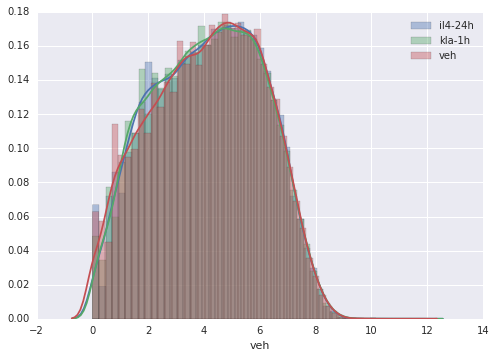

In [123]:
for treatment in h3k27ac_meanQuantileTag_frame:
    sns.distplot(np.log2(h3k27ac_meanQuantileTag_frame[treatment]+ 1) , label = treatment)
plt.legend()

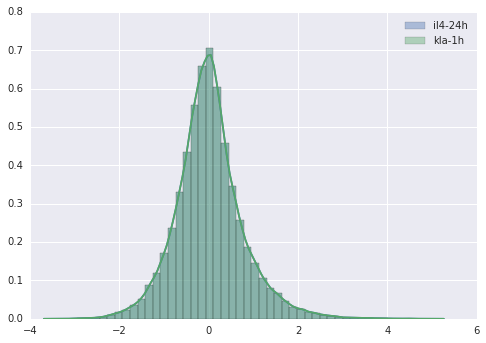

In [127]:
for treatment in h3k27ac_meanQuantileTag_frame:
    if not treatment == 'veh':
        sns.distplot(np.log2((h3k27ac_meanQuantileTag_frame['il4-24h'] + 1) / (h3k27ac_meanQuantileTag_frame['veh'] + 1)),
                     label = treatment)
plt.legend()



### Read in Sequence Data

In [109]:
len(set(seq_ids) - set(h3k27ac_meanQuantileTag_frame.index.values))

0

In [101]:
positive_seqRecords = list(SeqIO.parse('./merged_veh_kla_il4_peaks_resized.fasta', 'fasta'))
positive_seqRecords = [x for x in positive_seqRecords]
fasta_seq = [str(x.seq[:200]) for x in positive_seqRecords]

fasta_rc_seq = [str(x[:200].reverse_complement().seq) for x in positive_seqRecords ]

seq_ids = [x.name for x in positive_seqRecords]

sequence_arrays = convert_sequences_to_array(fasta_seq)
sequence_arrays = np.array(sequence_arrays)

sequence_rc_arrays = convert_sequences_to_array(fasta_rc_seq)
sequence_rc_arrays = np.array(sequence_rc_arrays)

index_seqArray_dict = dict(zip(seq_ids, zip(sequence_arrays, sequence_rc_arrays)))

In [128]:
h3k27ac_meanQuantileTag_frame.columns

Index(['il4-24h', 'kla-1h', 'veh'], dtype='object')

In [1335]:
pseudocount = 10
treatment = 'kla-1h'
# treatment = 'veh'
# treatment = 'il4-24h'
labels = np.log2((h3k27ac_meanQuantileTag_frame.loc[seq_ids,treatment] + pseudocount)/
                 (h3k27ac_meanQuantileTag_frame.loc[seq_ids,'veh'] + pseudocount)).values
# labels = ((h3k27ac_meanQuantileTag_frame.loc[seq_ids,treatment] + pseudocount)/
#          (h3k27ac_meanQuantileTag_frame.loc[seq_ids,'veh'] + pseudocount)).values
# labels = np.log2(h3k27ac_meanQuantileTag_frame.loc[seq_ids, treatment] + 1)
# labels = np.log2(h3k27ac_meanTag_frame.loc[seq_ids, treatment] + 1)
# labels = h3k27ac_meanTag_frame.loc[seq_ids, treatment]

x_train, x_test, x_rc_train, x_rc_test, y_train, y_test = model_selection.train_test_split(sequence_arrays, sequence_rc_arrays, labels, test_size=0.2)


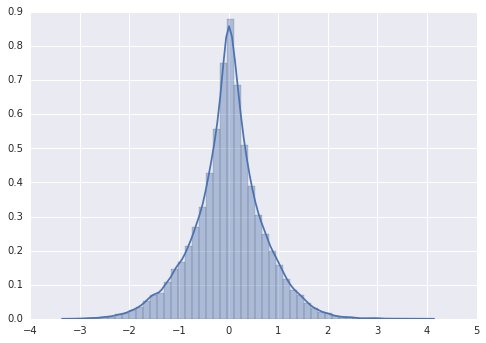

In [1336]:
sns.distplot(labels)

## Additive Attention

In [1337]:
def get_additiveAttention_regression_model(total_seq_length,
                        num_classes = 2,
                        num_motifs=32, 
                        motif_size=10,
                        adjacent_bp_pool_size=10,
                        attention_dim=32,
                        attention_hops=1,
                        num_dense_neurons=32,
                        dropout_rate=0.5):
    input_fwd = Input(shape=(total_seq_length,4), name='input_fwd')
    input_rev = Input(shape=(total_seq_length,4), name='input_rev')

    ### find motifs ###
    convolution_layer = Conv1D(filters=num_motifs, 
        kernel_size=motif_size,
        activation='relu',
        input_shape=(total_seq_length,4),
        name='convolution_layer',
        padding = 'same'
        )
    forward_motif_scores = convolution_layer(input_fwd)
    ### attention tanh layer ###
    attention_tanh_layer = Dense(attention_dim,
        activation='tanh',
        use_bias=False,
        name = 'attention_tanh_layer')
    attention_tanh_layer_out = attention_tanh_layer(forward_motif_scores)

    ### outer layer ###
    attention_outer_layer = Dense(attention_hops,
        activation='linear',
        use_bias=False,
        name = 'attention_outer_layer')
    attention_outer_layer_out = attention_outer_layer(attention_tanh_layer_out)

    
    ### apply softmax ###
    softmax_layer = Softmax(axis=1, name='attention_softmax_layer')
    attention_softmax_layer_out = softmax_layer(attention_outer_layer_out)

    ### attention dropout ###
    attention_dropout_layer = Dropout(dropout_rate, name='attention_dropout')
    attention_dropout_layer_out = attention_dropout_layer(attention_softmax_layer_out)
    
    ### attend to hidden states ###
    attending_layer = Dot(axes=(1,1),
        name='attending_layer')

    attended_states = attending_layer([attention_dropout_layer_out, forward_motif_scores])

    ### fully connected layer ###
    dense_layer = Dense(num_dense_neurons, 
        activation='linear', 
        name = 'dense_layer'
        )

    dense_output = dense_layer(attended_states)
    
    # drop out
    drop_out = Dropout(dropout_rate,name='dense_dropout')(dense_output)
    
    # make prediction
    flattened = Flatten(name='flatten')(drop_out)
    
    predictions = Dense(num_classes,
                        name='predictions',
                        activation = 'linear', 
                       )(flattened)
    
    # define and compile model
    model = Model(inputs=[input_fwd, input_rev], outputs=predictions)

    model.compile(loss=keras.losses.mean_squared_logarithmic_error,
                  optimizer=keras.optimizers.RMSprop(),
                  metrics=[pearson_correlation])
    return model

In [1338]:
additiveProductAttention_regression_model = get_additiveAttention_regression_model(
    200,
    num_classes = 1,
    num_motifs=150, 
    motif_size=10,
    adjacent_bp_pool_size=10,
    attention_dim=10,
    attention_hops=1,
    num_dense_neurons=50,
    dropout_rate=0.1)

In [1339]:
additiveProductAttention_regression_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_fwd (InputLayer)          (None, 200, 4)       0                                            
__________________________________________________________________________________________________
convolution_layer (Conv1D)      (None, 200, 150)     6150        input_fwd[0][0]                  
__________________________________________________________________________________________________
attention_tanh_layer (Dense)    (None, 200, 10)      1500        convolution_layer[0][0]          
__________________________________________________________________________________________________
attention_outer_layer (Dense)   (None, 200, 1)       10          attention_tanh_layer[0][0]       
__________________________________________________________________________________________________
attention_

In [1340]:
additiveProductAttention_regression_model.count_params()

15261

In [1341]:
additiveProductAttention_regression_model.fit([x_train, x_rc_train], y_train,
              batch_size=64,
              epochs=10,
              verbose=1,
              validation_data=([x_test, x_rc_test], y_test))



Train on 36295 samples, validate on 9074 samples
Epoch 1/10
36295/36295 [==============================] - 21s 577us/step - loss: 0.0696 - pearson_correlation: 0.2358 - val_loss: 0.0713 - val_pearson_correlation: 0.2533
Epoch 2/10
36295/36295 [==============================] - 13s 353us/step - loss: 0.0675 - pearson_correlation: 0.2769 - val_loss: 0.0682 - val_pearson_correlation: 0.2771
Epoch 3/10
36295/36295 [==============================] - 12s 317us/step - loss: 0.0666 - pearson_correlation: 0.2960 - val_loss: 0.0671 - val_pearson_correlation: 0.2883
Epoch 4/10
36295/36295 [==============================] - 12s 332us/step - loss: 0.0661 - pearson_correlation: 0.3088 - val_loss: 0.0684 - val_pearson_correlation: 0.2952
Epoch 5/10
36295/36295 [==============================] - 12s 326us/step - loss: 0.0656 - pearson_correlation: 0.3163 - val_loss: 0.0676 - val_pearson_correlation: 0.3014
Epoch 6/10
36295/36295 [==============================] - 11s 315us/step - loss: 0.0651 - pearso

In [1342]:
predictions = additiveProductAttention_regression_model.predict([sequence_arrays, sequence_rc_arrays])

print(scipy.stats.pearsonr(labels, predictions.flatten()))
print(scipy.stats.pearsonr(np.log2(labels+1), np.log2(predictions.flatten()+1)))
print(scipy.stats.pearsonr(np.exp2(labels), np.exp2(predictions.flatten())))





(0.3600528031644052, 0.0)
(nan, 1.0)
(0.35696409479817115, 0.0)


/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log2
  after removing the cwd from sys.path.


/home/jtao/software/anaconda3/lib/python3.5/site-packages/numpy/ma/core.py:6434: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/home/jtao/software/anaconda3/lib/python3.5/site-packages/numpy/ma/core.py:6434: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


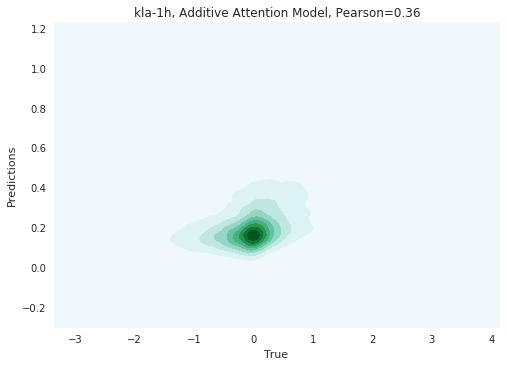

In [1343]:

pearson, _ = scipy.stats.pearsonr(labels, predictions.flatten())
sns.kdeplot(labels, predictions.flatten(), shade = True)
ax = plt.gca()
ax.set_aspect(ax.get_xlim()[1]/ax.get_ylim()[1])
plt.xlabel('True')
plt.ylabel('Predictions')
plt.title(treatment + ', Additive Attention Model, Pearson='+str(np.round(pearson,3)))

## Dot Product Attention

In [1344]:
def root_mean_squared_log_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(K.log(y_pred + 1) - K.log(y_true + 1)), axis=-1)) 

In [1345]:
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1)) 

In [1346]:
def pearson_correlation(y_true, y_pred):
    mean_true = tf.reduce_mean(y_true)
    mean_pred = tf.reduce_mean(y_pred)
    diff_true = y_true - mean_true
    diff_pred = y_pred - mean_pred
    
    
    diff_true_squared = tf.sqrt(tf.reduce_sum(tf.square(y_true - mean_true)))
    diff_pred_squared = tf.sqrt(tf.reduce_sum(tf.square(y_pred - mean_pred)))
    correlation = tf.reduce_sum(diff_true * diff_pred)/(diff_true_squared * diff_pred_squared)
    return correlation
    


In [1347]:
def element_multiply (x,y):
    x_shape = []
    for i, s in zip(K.int_shape(x), tf.unstack(tf.shape(x))):
        if i is not None:
            x_shape.append(i)
        else:
            x_shape.append(s)
    x_shape = tuple(x_shape)
    y_shape = []
    for i, s in zip(K.int_shape(y), tf.unstack(tf.shape(y))):
        if i is not None:
            y_shape.append(i)
        else:
            y_shape.append(s)
    y_shape = tuple(y_shape)

    xt = tf.reshape(x, [-1, x_shape[-1],1])
    yt = tf.reshape(y, [y_shape[-2],1])

    return tf.multiply(xt,yt)

class Projection(Layer):
    """
    Learn linear transform of imput tensor
    """
    def __init__(self, units,
                 kernel_initializer='glorot_uniform',
                 kernel_constraint=None,
                 **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(Projection, self).__init__(**kwargs)
        self.units = units
        self.activation = activations.tanh
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.kernel_constraint = constraints.get(kernel_constraint)
        self.input_spec = InputSpec(min_ndim=2)
        self.supports_masking = True

    def build(self, input_shape):
        assert len(input_shape) >= 2
        input_dim = input_shape[-1]

        self.kernel = self.add_weight(shape=(input_dim, self.units),
                                      initializer=self.kernel_initializer,
                                      name='kernel',
                                      constraint=self.kernel_constraint)

        self.input_spec = InputSpec(min_ndim=2, axes={-1: input_dim})
        self.built = True

    
    def call(self, inputs):
        output = element_multiply(inputs, self.kernel)
        output = self.activation(output)
        
        return output

In [1354]:
def get_dotProductAttention_regression_model(total_seq_length,
    num_classes = 1,
    seq_size=150,
    num_motifs=150, 
    motif_size=10,
    adjacent_bp_pool_size=10,
    num_dense_neurons=50,
    dropout_rate=0.75):
    input_fwd = Input(shape=(total_seq_length,4), name='input_fwd')
    input_rev = Input(shape=(total_seq_length,4), name='input_rev')

    ### find motifs ###
    convolution_layer = Conv1D(filters=num_motifs, 
        kernel_size=motif_size,
        activation='relu',
        input_shape=(total_seq_length,4),
        name='convolution_layer',
        padding = 'same'
        )
    forward_motif_scores = convolution_layer(input_fwd)
    reverse_motif_scores = convolution_layer(input_rev)

    ### crop motif scores to avoid parts of sequence where motif score is computed in only one direction ###
    to_crop = int((total_seq_length - seq_size)/2)
    crop_layer = Cropping1D(cropping=(to_crop, to_crop), 
        name='crop_layer')
    cropped_fwd_scores = crop_layer(forward_motif_scores)
#     cropped_rev_scores = crop_layer(reverse_motif_scores)

    ### flip motif scores ###
#     flip_layer = Lambda(lambda x: K.reverse(x,axes=0),
#         output_shape=(seq_size, num_motifs),
#         name='flip_layer')
#     flipped_rev_scores = flip_layer(cropped_rev_scores)

    ### concatenate motif scores ###
#     concatenate_layer = keras.layers.Concatenate(axis=2, name='concatenate_layer')
#     concatenated_motif_scores = concatenate_layer([cropped_fwd_scores, flipped_rev_scores])
    concatenated_motif_scores = cropped_fwd_scores
    ### pool across length of sequence ###
    sequence_pooling_layer = MaxPool1D(pool_size=adjacent_bp_pool_size, 
        strides=adjacent_bp_pool_size,
        name='sequence_pooling_layer')
    pooled_scores = sequence_pooling_layer(concatenated_motif_scores)
        
    ### compute attention ###
    ### weight queries ###
    query_transformer = TimeDistributed(Projection(units=1), 
                                        input_shape=(int(seq_size/adjacent_bp_pool_size), num_motifs*2),
                                        name='query_transformer'
                                       )
    weighted_queries = query_transformer(pooled_scores)
    
    ### weight keys ###
    key_transformer = TimeDistributed(Projection(units=1), 
                                      input_shape=(int(seq_size/adjacent_bp_pool_size), num_motifs*2),
                                      name = 'key_transformer')
    weighted_keys = key_transformer(pooled_scores)
    
    dot_product = Dot(axes=(2,2),name='dot_product')
    attention_weights = dot_product([weighted_queries, weighted_keys])

    ### apply softmax ###
    softmax_layer = Softmax(axis=1, name='attention_softmax_layer')
    attention_softmax_layer_out = softmax_layer(attention_weights)
    
    attention_dropout_layer = Dropout(dropout_rate, name='attention_dropout')
    attention_dropout_layer_out = attention_dropout_layer(attention_softmax_layer_out)
    
    ### weight values ###
    value_transformer = TimeDistributed(Projection(units=1), 
                                        input_shape=(int(seq_size/adjacent_bp_pool_size), num_motifs*2),
                                        name='value_transformer'
                                       )
    
    weighted_values = value_transformer(pooled_scores)
    
    ### attend to hidden states ###
    attending_layer = Dot(axes=(1,1),
        name='attending_layer')
    attended_states = attending_layer([attention_dropout_layer_out, weighted_values])
    
    ### fully connected layer ###
    dense_layer = Dense(num_dense_neurons, 
        activation='linear', 
        name = 'dense_layer'
        )

    dense_output = dense_layer(attended_states)
    
    # drop out
    drop_out = Dropout(dropout_rate,name='dense_dropout')(dense_output)
    
    # make prediction
    flattened = Flatten(name='flatten')(drop_out)
    
    predictions = Dense(num_classes,
                        name='predictions',
                        activation = 'linear', 
                       )(flattened)
    
    # define and compile model
    model = Model(inputs=[input_fwd, input_rev], outputs=predictions)

    model.compile(
#         loss= root_mean_squared_log_error,
#         loss = root_mean_squared_error,
        loss=keras.losses.mean_squared_logarithmic_error,
        optimizer = keras.optimizers.RMSprop(),
        metrics = [pearson_correlation])


    return model


In [1355]:
dotProductAttention_regression_model = get_dotProductAttention_regression_model(200,
    num_classes = 1,
    seq_size=150,
    num_motifs=150, 
    motif_size=10,
    adjacent_bp_pool_size=10,
    num_dense_neurons=50,
    dropout_rate=0.1)

In [1356]:
# SVG(model_to_dot(dotProductAttention_model, show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))

In [1357]:
# dotProductAttention_regression_model.summary()

In [1358]:
dotProductAttention_regression_model.count_params()

14901

In [1359]:
dotProductAttention_regression_model.fit([x_train, x_rc_train], y_train,
              batch_size=64,
              epochs=10,
              verbose=1,
              validation_data=([x_test, x_rc_test], y_test))



Train on 36295 samples, validate on 9074 samples
Epoch 1/10
36295/36295 [==============================] - 21s 590us/step - loss: 0.0701 - pearson_correlation: 0.2339 - val_loss: 0.0690 - val_pearson_correlation: 0.2535
Epoch 2/10
36295/36295 [==============================] - 13s 348us/step - loss: 0.0685 - pearson_correlation: 0.2652 - val_loss: 0.0803 - val_pearson_correlation: 0.2655
Epoch 3/10
36295/36295 [==============================] - 13s 350us/step - loss: 0.0676 - pearson_correlation: 0.2799 - val_loss: 0.0799 - val_pearson_correlation: 0.2747
Epoch 4/10
36295/36295 [==============================] - 13s 350us/step - loss: 0.0671 - pearson_correlation: 0.2951 - val_loss: 0.0713 - val_pearson_correlation: 0.2820
Epoch 5/10
36295/36295 [==============================] - 13s 348us/step - loss: 0.0667 - pearson_correlation: 0.3030 - val_loss: 0.0685 - val_pearson_correlation: 0.2916
Epoch 6/10
36295/36295 [==============================] - 13s 349us/step - loss: 0.0662 - pearso

In [1360]:
predictions = dotProductAttention_regression_model.predict([sequence_arrays, sequence_rc_arrays])


print(scipy.stats.pearsonr(labels, predictions.flatten()))
print(scipy.stats.pearsonr(np.log2(labels+1), np.log2(predictions.flatten()+1)))
print(scipy.stats.pearsonr(np.exp2(labels), np.exp2(predictions.flatten())))





(0.360797164276232, 0.0)
(nan, 1.0)
(0.35425005024301776, 0.0)


/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log2
  """


/home/jtao/software/anaconda3/lib/python3.5/site-packages/numpy/ma/core.py:6434: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/home/jtao/software/anaconda3/lib/python3.5/site-packages/numpy/ma/core.py:6434: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


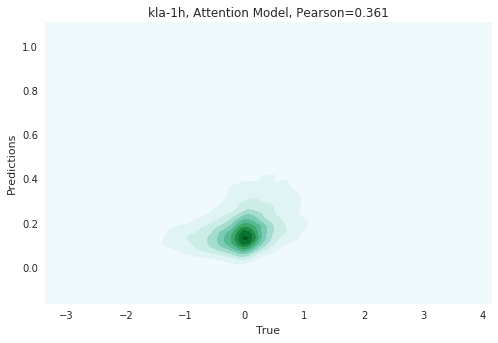

In [1361]:

pearson, _ = scipy.stats.pearsonr(labels, predictions.flatten())
sns.kdeplot(labels, predictions.flatten(), shade = True)
ax = plt.gca()
ax.set_aspect(ax.get_xlim()[1]/ax.get_ylim()[1])
plt.xlabel('True')
plt.ylabel('Predictions')
plt.title(treatment + ', Attention Model, Pearson='+str(np.round(pearson,3)))

## Compare against Convolution

In [1362]:
def get_convolution_regression_model(
    total_seq_length=200,
    seq_size = 150,
    num_classes = 1,
    num_motifs = 150,
    motif_size = 10,
    num_dense_neurons = 50, 
    dropout_rate = 0.75
    ):
    input_fwd = Input(shape=(total_seq_length,4), name='input_fwd')
    input_rev = Input(shape=(total_seq_length,4), name='input_rev')

    # find motifs
    convolution_layer = Conv1D(filters=num_motifs, 
        kernel_size=motif_size,
        activation='relu',
        input_shape=(total_seq_length,4),
        name='convolution_layer',
        padding = 'same'
        )
    forward_motif_scores = convolution_layer(input_fwd)
    reverse_motif_scores = convolution_layer(input_rev)

    # crop motif scores to avoid parts of sequence where motif score is computed in only one direction
    to_crop = int((total_seq_length - seq_size)/2)
    crop_layer = Cropping1D(cropping=(to_crop, to_crop), 
        name='crop_layer')
    cropped_fwd_scores = crop_layer(forward_motif_scores)
    cropped_rev_scores = crop_layer(reverse_motif_scores)

    # calculate max scores for each orientation
    seq_pool_layer = MaxPool1D(pool_size=seq_size)
    max_fwd_scores = seq_pool_layer(cropped_fwd_scores)
    max_rev_scores = seq_pool_layer(cropped_rev_scores)

    # calculate max score for strand
    orientation_max_layer = Maximum()
    max_seq_scores = orientation_max_layer([max_fwd_scores, max_rev_scores])

    # fully connected layer
    dense_out = Dense(num_dense_neurons, activation='linear', 
                     )(max_seq_scores)

    # drop out
    drop_out = Dropout(dropout_rate)(dense_out)

    # make prediction
    flattened = Flatten()(drop_out)
    predictions = Dense(num_classes,
                        activation = 'linear', 
                       )(flattened)
    
    # define and compile model
    convolution_model = Model(inputs=[input_fwd, input_rev], outputs=predictions)
    convolution_model.compile(loss=keras.losses.mean_squared_logarithmic_error,
                  optimizer = keras.optimizers.RMSprop(),
                  metrics = [pearson_correlation])
    return convolution_model

In [1363]:
convolution_regression_model = get_convolution_regression_model(200,
    num_classes = 1,
    seq_size=150,
    num_motifs=150, 
    motif_size=24,
    num_dense_neurons=50,
    dropout_rate=0.75)

In [1364]:
convolution_regression_model.count_params()

22151

In [1365]:
convolution_regression_model.fit([x_train, x_rc_train], y_train,
      batch_size=64,
      epochs=10,
      verbose=2,
      validation_data=([x_test, x_rc_test], y_test))

Train on 36295 samples, validate on 9074 samples
Epoch 1/10
 - 23s - loss: 0.1083 - pearson_correlation: 0.0090 - val_loss: 0.1082 - val_pearson_correlation: 0.1024
Epoch 2/10
 - 15s - loss: 0.1082 - pearson_correlation: 0.0050 - val_loss: 0.1082 - val_pearson_correlation: 0.1042
Epoch 3/10
 - 15s - loss: 0.1082 - pearson_correlation: 0.0073 - val_loss: 0.1082 - val_pearson_correlation: 0.1042
Epoch 4/10
 - 15s - loss: 0.1082 - pearson_correlation: 0.0072 - val_loss: 0.1082 - val_pearson_correlation: 0.1042
Epoch 5/10
 - 15s - loss: 0.1082 - pearson_correlation: 0.0050 - val_loss: 0.1082 - val_pearson_correlation: 0.1042
Epoch 6/10
 - 15s - loss: 0.1082 - pearson_correlation: 0.0040 - val_loss: 0.1082 - val_pearson_correlation: 0.1042
Epoch 7/10
 - 15s - loss: 0.1082 - pearson_correlation: -5.5534e-03 - val_loss: 0.1082 - val_pearson_correlation: 0.1042
Epoch 8/10
 - 15s - loss: 0.1082 - pearson_correlation: 0.0057 - val_loss: 0.1082 - val_pearson_correlation: 0.1042
Epoch 9/10
 - 15s 

In [1366]:
predictions = convolution_regression_model.predict([sequence_arrays, sequence_rc_arrays])

print(scipy.stats.pearsonr(labels, predictions.flatten()))
print(scipy.stats.pearsonr(np.log2(labels+1), np.log2(predictions.flatten()+1)))
print(scipy.stats.pearsonr(np.exp2(labels), np.exp2(predictions.flatten())))

(0.10760584173429476, 6.408912042034208e-117)
(nan, 1.0)
(0.10186756293340295, 6.3588729709350844e-105)


/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log2
  after removing the cwd from sys.path.


/home/jtao/software/anaconda3/lib/python3.5/site-packages/numpy/ma/core.py:6434: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/home/jtao/software/anaconda3/lib/python3.5/site-packages/numpy/ma/core.py:6434: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


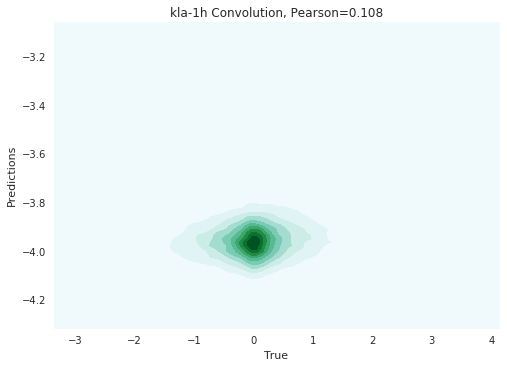

In [1373]:

pearson, _ = scipy.stats.pearsonr(labels, predictions.flatten())
sns.kdeplot(labels, predictions.flatten(), shade = True)
# ax = plt.gca()
# ax.set_aspect(ax.get_xlim()[1]/ax.get_ylim()[1])
plt.xlabel('True')
plt.ylabel('Predictions')
plt.title(treatment + ' Convolution, Pearson='+str(np.round(pearson,3)))

## Compare against Logistic Regression

In [1368]:
def get_regression_model(
    total_seq_length=200,
    seq_size = 150,
    num_classes = 1,
    num_motifs = 150,
    motif_size = 10,
    ):
    input_fwd = Input(shape=(total_seq_length,4), name='input_fwd')
    input_rev = Input(shape=(total_seq_length,4), name='input_rev')

    # find motifs
    regression_layer = Conv1D(filters=num_motifs, 
        kernel_size=motif_size,
        activation='relu',
        input_shape=(total_seq_length,4),
        name='regression_layer',
        padding = 'same'
        )
    forward_motif_scores = regression_layer(input_fwd)
    reverse_motif_scores = regression_layer(input_rev)

    # crop motif scores to avoid parts of sequence where motif score is computed in only one direction
    to_crop = int((total_seq_length - seq_size)/2)
    crop_layer = Cropping1D(cropping=(to_crop, to_crop), 
        name='crop_layer')
    cropped_fwd_scores = crop_layer(forward_motif_scores)
    cropped_rev_scores = crop_layer(reverse_motif_scores)

    # calculate max scores for each orientation
    seq_pool_layer = MaxPool1D(pool_size=seq_size)
    max_fwd_scores = seq_pool_layer(cropped_fwd_scores)
    max_rev_scores = seq_pool_layer(cropped_rev_scores)

    # calculate max score for strand
    orientation_max_layer = Maximum()
    max_seq_scores = orientation_max_layer([max_fwd_scores, max_rev_scores])

    flattened = Flatten()(max_seq_scores)
    # fully connected layer
    predictions = Dense(num_classes, activation='linear', 
                     )(flattened)

    # define and compile model
    regression_model = Model(inputs=[input_fwd, input_rev], outputs=predictions)
    regression_model.compile(loss=keras.losses.mean_squared_logarithmic_error,
                  optimizer = keras.optimizers.RMSprop(),
                  metrics = [pearson_correlation])
    return regression_model

In [1369]:
regression_model = get_regression_model(200,
    num_classes = 1,
    seq_size=150,
    num_motifs=150, 
    motif_size=24)

In [1370]:
regression_model.count_params()

14701

In [1371]:
regression_model.fit([x_train, x_rc_train], y_train,
      batch_size=64,
      epochs=10,
      verbose=2,
      validation_data=([x_test, x_rc_test], y_test))

Train on 36295 samples, validate on 9074 samples
Epoch 1/10
 - 23s - loss: 0.1082 - pearson_correlation: nan - val_loss: 0.1082 - val_pearson_correlation: nan
Epoch 2/10
 - 15s - loss: 0.1082 - pearson_correlation: nan - val_loss: 0.1082 - val_pearson_correlation: nan
Epoch 3/10
 - 15s - loss: 0.1082 - pearson_correlation: nan - val_loss: 0.1082 - val_pearson_correlation: nan
Epoch 4/10
 - 15s - loss: 0.1082 - pearson_correlation: nan - val_loss: 0.1082 - val_pearson_correlation: nan
Epoch 5/10
 - 15s - loss: 0.1082 - pearson_correlation: nan - val_loss: 0.1082 - val_pearson_correlation: nan
Epoch 6/10
 - 15s - loss: 0.1082 - pearson_correlation: nan - val_loss: 0.1082 - val_pearson_correlation: nan
Epoch 7/10
 - 15s - loss: 0.1082 - pearson_correlation: nan - val_loss: 0.1082 - val_pearson_correlation: nan
Epoch 8/10
 - 15s - loss: 0.1082 - pearson_correlation: nan - val_loss: 0.1082 - val_pearson_correlation: nan
Epoch 9/10
 - 15s - loss: 0.1082 - pearson_correlation: nan - val_loss:

In [1279]:
predictions = regression_model.predict([sequence_arrays, sequence_rc_arrays])
print(scipy.stats.pearsonr(labels, predictions.flatten()))
print(scipy.stats.pearsonr(np.log2(labels+1), np.log2(predictions.flatten()+1)))
print(scipy.stats.pearsonr(np.exp2(labels), np.exp2(predictions.flatten())))

(nan, 1.0)
(nan, 1.0)
(nan, 1.0)


/home/jtao/software/anaconda3/lib/python3.5/site-packages/scipy/stats/stats.py:3021: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
/home/jtao/software/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log2
  This is separate from the ipykernel package so we can avoid doing imports until


/home/jtao/software/anaconda3/lib/python3.5/site-packages/numpy/ma/core.py:6434: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/home/jtao/software/anaconda3/lib/python3.5/site-packages/numpy/ma/core.py:6434: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


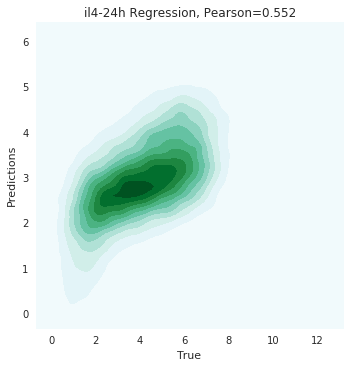

In [1223]:
pearson, _ = scipy.stats.pearsonr(labels, predictions.flatten())
sns.kdeplot(labels, predictions.flatten(), shade=True)
ax = plt.gca()
ax.set_aspect(ax.get_xlim()[1]/ax.get_ylim()[1])
plt.xlabel('True')
plt.ylabel('Predictions')
plt.title(treatment + ' Regression, Pearson='+str(np.round(pearson,3)))